In [1]:
# Input data
import numpy as np
from utilities import *

# test and train read
X_train_valid, Y_train_valid, list_ch_train_valid = read_data(data_path="../../datasets/har-data/", 
                                                              split="train")
X_test, Y_test, list_ch_test = read_data(data_path="../../datasets/har-data/", split="test")

assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)

print(np.mean(Y_train_valid==0), np.mean(Y_train_valid==1), np.mean(Y_train_valid==2), 
      np.mean(Y_train_valid==3), np.mean(Y_train_valid==4), np.mean(Y_train_valid==5),
      np.mean(Y_train_valid==6), np.mean(Y_train_valid==7))

0.0 0.16675734494 0.145946681175 0.134113166485 0.174918389554 0.186887921654 0.191376496192 0.0


In [2]:
# Preparing input and output data
# from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid).reshape(-1)==0), np.mean((Y_train_valid).reshape(-1)==1),
     np.mean((Y_train_valid).reshape(-1)==2), np.mean((Y_train_valid).reshape(-1)==3),
     np.mean((Y_train_valid).reshape(-1)==4), np.mean((Y_train_valid).reshape(-1)==5),
     np.mean((Y_train_valid).reshape(-1)==6), np.mean((Y_train_valid).reshape(-1)==7))

Y_train_valid_onehot = one_hot(labels=Y_train_valid.reshape(-1), n_class=6) 
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=6) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.16675734494 0.145946681175 0.134113166485 0.174918389554 0.186887921654 0.191376496192 0.0
(7352, 6) float64 (2947, 6) float64


In [3]:
# Train and valid split
from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(5146, 128, 9) (2206, 128, 9) (5146, 6) (2206, 6)


In [4]:
## Hyperparameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 1 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 51 128 9
n_classes 6


In [5]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [6]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [7]:
# batch_size, seq_len, n_channels: 51 128 9; n_classes: 6
# (batch, 128, 9) --> (batch, 256, 18)
# conv same
# pool same: (128-2+0)/2 + 1 = (126/2)+1 = 63 + 1=64
conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 64, 18) --> (batch, 32, 36)
# conv same
# pool same: (64-2+0)/2 + 1 = (62/2)+1 = 31 + 1=32
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 32, 36) --> (batch, 16, 72)
# conv same
# pool same: (32-2+0)/2 + 1 = (30/2)+1 = 15 + 1=16
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 16, 72) --> (batch, 8, 144)
# conv same
# pool same: (16-2+0)/2 + 1 = (14/2)+1 = 7 + 1=8
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# # Flatten and add dropout + predicted output
# flat = tf.reshape(max_pool_4, (-1, 8*144))
# flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
# logits = tf.layers.dense(flat, n_classes)
# print('max_pool_4.shape, flat.shape, logits.shape', max_pool_4.shape, flat.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 128, 9) (?, 128, 18) (?, 64, 18)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 64, 18) (?, 64, 36) (?, 32, 36)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 32, 36) (?, 32, 72) (?, 16, 72)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 16, 72) (?, 16, 144) (?, 8, 144)


In [8]:
# Adjusting to the input from conv-pool layers (?, 8, 144)
# n_channels from conv output
# max_pool_4.shape: (?, 8, 144), (batch, seq_len, n_channel)
# n_ch = 2 * n_channel

# Construct the LSTM inputs and LSTM cells
# inputs_ (seq_len, N, n_channels)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
# n_channels = 144
lstm_in = tf.reshape(lstm_in, [-1, 144]) # Now (seq_len*N, n_channels)
print(inputs_.shape, lstm_in.shape)

# RNN-LSTM parameters
# n_channels = 144
lstm_size = 3 * 144 # 3 times the amount of channels
lstm_layers = 1 # Number of layers
print(lstm_size)

# To cells
lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?

# Open up the tensor into a list of seq_len pieces
# seq_len = 8
lstm_in = tf.split(lstm_in, 8, 0)

(?, 128, 9) (?, 144)
432


In [9]:
# Add LSTM layers
lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
cell = tf.nn.rnn_cell.MultiRNNCell([drop] * lstm_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

In [10]:
outputs, final_state = tf.nn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state = initial_state)

# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')

In [11]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# Confusion matrix
confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("Reshape_3:0", shape=(51,), dtype=float32) Tensor("Mean:0", shape=(), dtype=float32)
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_dense/kernel/ApplyAdam"
input: "^Adam/update_dense/bias/ApplyAdam"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/ApplyAdam"
input: "^Adam/update_rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias/ApplyAdam"
input: "^Adam/update_logits/kernel/ApplyAdam"
input: "^Adam/update_logits/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"

correct_pred, accuracy Tensor("Equal:0", shape=(51,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)
confusion_matrix Tensor("confusion_matrix/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [12]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, initial_state : state, 
                    learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            state_valid = sess.run(cell.zero_state(batch_size, tf.float32))
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0, initial_state : state_valid}

                # Loss
                loss, state_valid, acc = sess.run([cost, final_state, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints/dcnn-lstm-har.ckpt")

Epoch: 1/1 Train loss: 1.835445 Valid loss: 1.801804 Train acc: 0.169608 Valid acc: 0.186854


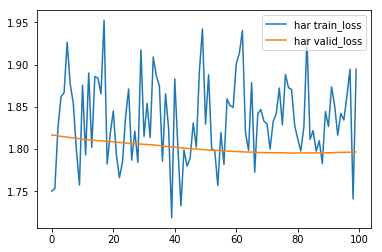

In [13]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

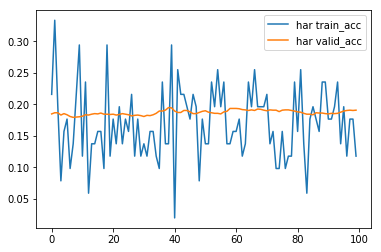

In [14]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='har train_acc')
mplot.plot(valid_acc, label='har valid_acc')
mplot.legend()
mplot.show()

In [15]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    ################## Test
    state = sess.run(cell.zero_state(batch_size, tf.float32))
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0, initial_state : state}

        # Loss
        loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/dcnn-lstm-har.ckpt
Test loss: 1.733549 Test acc: 0.251806
